In [58]:
import jax
import jax.numpy as jnp
import scipy
from sklearn.datasets import make_classification
import numpy as np
from tqdm import trange
try:
  import optax
except ModuleNotFoundError:
  %pip install -q optax
  import optax
try:
  import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
  %pip install -q tensorflow-probability
  import tensorflow_probability.substrates.jax as tfp
tfd=tfp.distributions
import seaborn as sns
import matplotlib.pyplot as plt

### **Data creation**

In [59]:
num_samples= 50
num_features = 4
x, y = make_classification(
    n_features = num_features, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1,n_samples=num_samples
)
rng = np.random.RandomState(2)
x += 2 * rng.uniform(size=x.shape)

In [78]:
X.shape

(50, 5)

In [60]:
def low_rank_approximation(X, M):
    if X.shape[0] == M or X.shape[1] == M:
        _, _, UT = jnp.linalg.svd(X, full_matrices=False) # U is shape [N, M=D]
        U = UT.T
    else:
        _,_,UT = scipy.sparse.linalg.svds(X, k=M)
        U = UT.T
    XU = X @ U
    return XU, U

In [61]:
def identity_trans(x):
    return jnp.append(jnp.ones((num_samples,1)),x,axis=1)

X=jnp.array(identity_trans(x))
X.shape,y.shape

((50, 5), (50,))

### **Low Rank Approximation (M = 4)**

In [62]:
M = 4

sigma_beta=jnp.ones(num_features+1)

XU,U=low_rank_approximation(X,M)
XU.shape, U.shape, (U.T).shape

((50, 4), (5, 4), (4, 5))

In [63]:
p_cov = (U.T)@(sigma_beta[:,None]*U)
p_cov,  p_cov.shape

(DeviceArray([[ 1.0000001e+00, -7.6207783e-08, -6.0430580e-08,
               -5.5263698e-08],
              [-7.6207783e-08,  9.9999994e-01,  7.0483974e-09,
                5.7910928e-08],
              [-6.0430580e-08,  7.0483974e-09,  9.9999988e-01,
                1.0441035e-09],
              [-5.5263698e-08,  5.7910928e-08,  1.0441035e-09,
                1.0000002e+00]], dtype=float32),
 (4, 4))

In [64]:
def neg_logjoint(UT_bmap, XU,y):
    l = tfd.Bernoulli(probs=jax.nn.sigmoid(XU @ UT_bmap))
    p=tfd.MultivariateNormalFullCovariance(loc=jnp.zeros(M), covariance_matrix=p_cov)
    return -(l.log_prob(y).sum()+p.log_prob(UT_bmap))

In [65]:
gradient=jax.value_and_grad(jax.jit(neg_logjoint))
seed=jax.random.PRNGKey(0)
UT_bmap = jax.random.uniform(shape=(M,), key=seed)
lr=0.01
optimizer = optax.adam(learning_rate=lr)
state = optimizer.init(UT_bmap)
losses = []
max_iter=1000
for _ in trange(max_iter):
    val, grad = gradient(UT_bmap, XU,y)
    losses.append(val)
    update, state = optimizer.update(grad, state)
    UT_bmap = optax.apply_updates(UT_bmap, update)
loss=losses
UT_bmap

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.58it/s]


DeviceArray([0.96619713, 0.4377509 , 1.7501996 , 0.356645  ], dtype=float32)

In [66]:
mu_n=U@UT_bmap
mu_n

DeviceArray([ 0.2875426 ,  0.51217115,  0.06244337,  0.12543465,
             -1.987693  ], dtype=float32)

In [67]:
def logjoint(UT_bmap, XU,y):
    l = tfd.Bernoulli(probs=jax.nn.sigmoid(XU @ UT_bmap))
    p=tfd.MultivariateNormalFullCovariance(loc=jnp.zeros(M), covariance_matrix=jnp.identity(M))
    return (l.log_prob(y).sum())

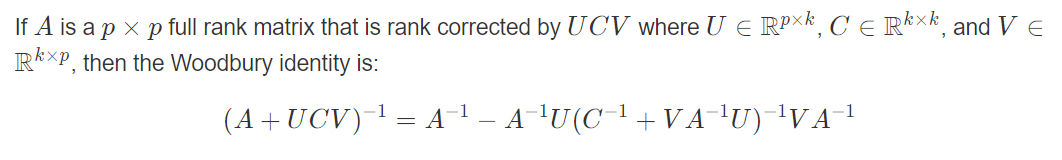

In [68]:
H=jax.hessian(logjoint)(UT_bmap,XU,y)
H_inverse=jnp.linalg.inv(H)

H_inverse.shape

(4, 4)

In [69]:
W_inverse=(U.T)@(sigma_beta[:,None]*U)-H_inverse

W=jnp.linalg.inv(W_inverse)
W.shape

(4, 4)

In [70]:
sigma_n=jnp.diag(sigma_beta)-(sigma_beta[:,None]*U)@W@((U.T)*sigma_beta[None])
sigma_n.shape

(5, 5)

In [71]:
laplace_approx_lr = tfd.MultivariateNormalFullCovariance(loc=mu_n, covariance_matrix=sigma_n)
samples_lr = laplace_approx_lr.sample(sample_shape=(1000,), seed=jax.random.PRNGKey(0))

samples_lr.shape

(1000, 5)

### **Normal Laplace Approximation**

In [72]:
def neg_logjoint_normal(beta, X,y):
    l = tfd.Bernoulli(probs=jax.nn.sigmoid(X @ beta))
    p=tfd.MultivariateNormalFullCovariance(loc=jnp.zeros(num_features+1), covariance_matrix=jnp.identity(num_features+1))
    return -(l.log_prob(y).sum()+p.log_prob(beta))

In [73]:
gradient=jax.value_and_grad(jax.jit(neg_logjoint_normal))
seed=jax.random.PRNGKey(0)
theta_map = jax.random.uniform(shape=(num_features+1,), key=seed)
lr=0.01
optimizer = optax.adam(learning_rate=lr)
state = optimizer.init(theta_map)
losses = []
max_iter=1000
for _ in trange(max_iter):
    val, grad = gradient(theta_map, X,y)
    losses.append(val)
    update, state = optimizer.update(grad, state)
    theta_map = optax.apply_updates(theta_map, update)
loss=losses
theta_map

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.96it/s]


DeviceArray([ 0.31051508,  0.47043958,  0.06472641,  0.11497987,
             -1.8888317 ], dtype=float32)

In [74]:
hessian=jax.hessian(neg_logjoint_normal)(theta_map,X,y)

cov = jnp.linalg.inv(hessian)
cov.shape

(5, 5)

In [75]:
laplace_approx=tfd.MultivariateNormalFullCovariance(loc=theta_map, covariance_matrix=cov)
samples_normal = laplace_approx.sample(sample_shape=(1000,), seed=jax.random.PRNGKey(0))

### **Plot for comparison**

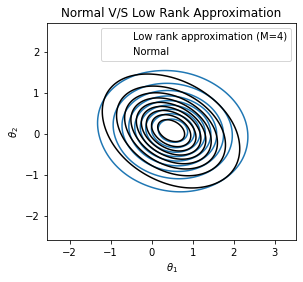

In [76]:
s = {r'$\theta_1$': samples_lr[:, 1], r'$\theta_2$': samples_lr[:, 2]}
ax = sns.kdeplot(data=s, x=r'$\theta_1$', y=r'$\theta_2$', label="Low rank approximation (M=4)",bw_adjust=4)

s1 = {r'$\theta_1$': samples_normal[:, 1], r'$\theta_2$': samples_normal[:, 2]}
ax = sns.kdeplot(data=s1, x=r'$\theta_1$', y=r'$\theta_2$', label="Normal",bw_adjust=4,color="black")

ax.set_title("Normal V/S Low Rank Approximation")
ax.set_aspect("equal")
plt.legend()